# Simple LSTM sentiment classifier

In this notebook, we use an LSTM to classify 'Yell polarity' reviews by their sentiment.  
You will need to run the CNN notebook first, to generate some of the tokenzed reviews.  

In [1]:
import keras
import pandas as pd
import os
import json
from multiprocessing import Pool
from time import time
from sklearn.metrics import roc_auc_score 

import matplotlib.pyplot as plt 
%matplotlib inline

/home/lindsay/anaconda3/envs/tf-gpu-src/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load data


In [2]:
train = pd.read_csv("../yelp_review_polarity_csv/train.csv", header=None)
train.columns = ["polarity", "review"]

Now you can jump to:  
* [Here to load the tokenized data](#tokenised-reviews)  
* [Here for pre-processed, tokenized data](#processed-tokens) 
* [Here for indexed reviews](#indexed-reviews)
<br></br>
**NB You will still need the raw data later!!**

### Load tokenized (lowered) reviews

In [3]:
with open("../processed_data/tokenised_reviews_lower.json", 'r') as f:
    reviews_lower = json.load(f)

In [4]:
[print(word) for word in reviews_lower[10]]

after
waiting
for
almost
30
minutes
to
trade
in
an
old
phone
part
of
the
buy
back
program
our
customer
service
rep
incorrectly
processed
the
transaction
this
led
to
us
waiting
another
30
minutes
for
him
to
correct
it
do
visit
this
store
if
you
want
pleasant
or
good
service


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

How long are the reviews?

In [5]:
review_lengths = [len(review) for review in reviews_lower]

(0, 200)

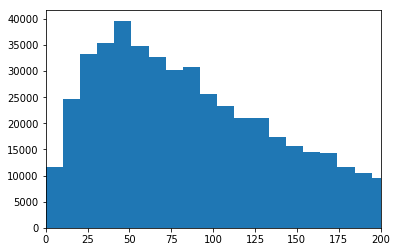

In [6]:
_ = plt.hist(review_lengths, bins=100)
plt.xlim(0,200)

**With stopwords**: Mode at 50-ish, with a long tail  
**Without stopwords**: Mode at 35-ish

### We need to index the words for Keras
We will stick to Keras' own convention and index by frequency

In [7]:
import itertools
from collections import Counter
words = list(itertools.chain(*reviews_lower))

In [8]:
start = time()
freq = Counter(words)
elapsed = time() - start

In [9]:
print("Time taken: {} s".format(elapsed))
print("Time per review: {} s".format(elapsed/len(reviews_lower)))
print("Estimated time for full dataset: {} mins".format(len(train)*elapsed/(len(reviews_lower)*60)))

Time taken: 9.368193626403809 s
Time per review: 1.67289171900068e-05 s
Estimated time for full dataset: 0.15613656044006347 mins


In [10]:
vocab = set(words)
vocab_lookup = {}
i = len(vocab) - 1
for word, _ in freq.most_common():
    vocab_lookup[word] = i
    i = i-1

#### Finally, index the reviews

In [11]:
start = time()
indexed_reviews = []
for review in reviews_lower:
    indexed_review = [vocab_lookup[word] for word in review]
    indexed_reviews.append(indexed_review)
elapsed = time() - start

In [12]:
print("Time taken: {} s".format(elapsed))
print("Time per review: {} s".format(elapsed/len(reviews_lower)))
print("Estimated time for full dataset: {} mins".format(len(train)*elapsed/(len(reviews_lower)*60)))

Time taken: 12.935360431671143 s
Time per review: 2.3098857913698468e-05 s
Estimated time for full dataset: 0.21558934052785236 mins


#### Translate a review back and check it's ok

In [13]:
[print(pair) for pair in zip( reviews_lower[15], [freq.most_common()[::-1][i] for i in indexed_reviews[15]])]

('very', ('very', 236765))
('disappointed', ('disappointed', 28862))
('in', ('in', 846797))
('the', ('the', 3684633))
('customer', ('customer', 46501))
('service', ('service', 202860))
('we', ('we', 624772))
('ordered', ('ordered', 107931))
('reuben', ('reuben', 795))
('and', ('and', 2411103))
('wanted', ('wanted', 52405))
('coleslaw', ('coleslaw', 1736))
('instead', ('instead', 25688))
('of', ('of', 1108030))
('kraut', ('kraut', 99))
('they', ('they', 591059))
('charged', ('charged', 11643))
('us', ('us', 152163))
('for', ('for', 861530))
('the', ('the', 3684633))
('coleslaw', ('coleslaw', 1736))
('we', ('we', 624772))
('will', ('will', 156489))
('not', ('not', 512208))
('be', ('be', 327248))
('back', ('back', 191857))
('the', ('the', 3684633))
('iced', ('iced', 5473))
('tea', ('tea', 17820))
('is', ('is', 851345))
('also', ('also', 118700))
('terrible', ('terrible', 21221))
('tasting', ('tasting', 8267))


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Additional processing
Each review needs to be:  
1. Filtered so that words occuring less than n times are replaces with 2 
2. Topped with a 1  

### Size of vocab is a key parameter

In [14]:
n_unique_words = 10000 # number of unique words to consider (i.e. most frequent) # HANDTUNED
OOV_CHAR = 2 # int with which to replace words that have been filtered out. 2 is consistent with Keras built-in value.

In [15]:
# cut off at:
wrd, i = freq.most_common()[n_unique_words]
print(wrd)
vocab_lookup[wrd]

involves


223306

In [16]:
def filter_review(review, cutoff=vocab_lookup[wrd]):
    # index from zero, plus the special characters
    filtered_review = [(elt - cutoff + OOV_CHAR) if elt > cutoff else OOV_CHAR for elt in review]
    return filtered_review

In [17]:
start = time()
p = Pool(6)
filtered_reviews = p.map(filter_review, indexed_reviews)
elapsed = time() - start

In [18]:
print("Time taken: {} s".format(elapsed))
print("Time per review: {} s".format(elapsed/len(reviews_lower)))
print("Estimated time for full dataset: {} mins".format(len(train)*elapsed/(len(reviews_lower)*60)))

Time taken: 17.22191286087036 s
Time per review: 3.0753415822982785e-05 s
Estimated time for full dataset: 0.287031881014506 mins


In [19]:
# finally, topping
topped_reviews = [[1] + review for review in filtered_reviews]

In [20]:
topped_reviews[15]

[1,
 9961,
 9671,
 9992,
 10002,
 9802,
 9949,
 9989,
 9918,
 5427,
 10001,
 9826,
 7240,
 9633,
 9995,
 2,
 9986,
 9310,
 9932,
 9994,
 10002,
 7240,
 9989,
 9937,
 9982,
 9975,
 9946,
 10002,
 8762,
 9500,
 9993,
 9921,
 9560,
 9096]

### Great!!

The next cell allows you to subselect data if training is taking toooooo looooooonnnnnnngggg

In [21]:
size_of_subset = len(topped_reviews) # currently set to entire dataset
subset = topped_reviews[:size_of_subset]
# sigmoid outputs 0 to 1, hence:
target = train['polarity'][:size_of_subset] - 1

### Split the indexed reviews into training and testing

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(subset, target, test_size=0.25)

In [23]:
# _ = plt.hist(X_train[:1000])
len(X_train)

420000

### Keras:

#### Preprocess data

In [24]:
from keras.preprocessing.sequence import pad_sequences

#### Set hyperparameters

In [25]:
# output directory name:
output_dir = '../model_output/simple_lstm'

# training:
epochs = 4 # HANDTUNED
batch_size = 128 # HANDTUNED

# vector-space embedding: 
max_review_length = 150 # HANDTUNED
n_dim = 64
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

# dense layer architecture: 
# n_dense = 256
# dropout = 0.2

In [26]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_test = pad_sequences(X_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.callbacks import ModelCheckpoint

#### Design neural network architecture

In [28]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(LSTM(n_lstm, dropout=drop_lstm))
# model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in NLP like in 
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [32]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[modelcheckpoint])

Train on 420000 samples, validate on 140000 samples
Epoch 1/4
420000/420000 [==============================] - 735s 2ms/step - loss: 0.2194 - acc: 0.9123 - val_loss: 0.1644 - val_acc: 0.9364
Epoch 2/4
420000/420000 [==============================] - 624s 1ms/step - loss: 0.1528 - acc: 0.9416 - val_loss: 0.1481 - val_acc: 0.9421
Epoch 3/4
420000/420000 [==============================] - 605s 1ms/step - loss: 0.1322 - acc: 0.9497 - val_loss: 0.1531 - val_acc: 0.9420
Epoch 4/4
420000/420000 [==============================] - 609s 1ms/step - loss: 0.1184 - acc: 0.9552 - val_loss: 0.1400 - val_acc: 0.9458


#### Evaluate
Best epoch was #4

In [33]:
model.load_weights(output_dir+"/weights.03.hdf5") # zero-indexed

In [34]:
y_hat = model.predict_proba(X_test)

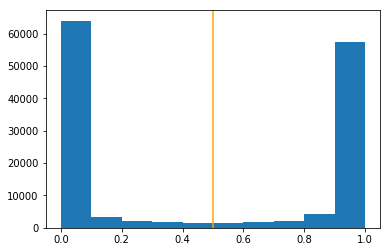

In [35]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [36]:
"{:0.2f}".format(roc_auc_score(y_test, y_hat)*100.0)

'98.72'